In [121]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load datasets
spotify = pd.read_csv("SpotifyTopSongsByCountry - May 2020.csv")
democracy = pd.read_csv("deliberative-democracy-index-vdem.csv")

# Compute proportion of explicit songs per country
spotify_explicit = (
    spotify.groupby(["Country", "Continent"])["Explicit"]
    .mean()
    .reset_index()
    .rename(columns={"Explicit": "Explicit_Proportion"})
)

# Filter democracy data for 2020
democracy_2020 = democracy[democracy["Year"] == 2020][
    ["Entity", "Deliberative democracy index (central estimate)"]
].rename(columns={
    "Entity": "Country",
    "Deliberative democracy index (central estimate)": "Democracy_Index"
})

# Merge both datasets
merged = pd.merge(spotify_explicit, democracy_2020, on="Country", how="inner")

# Build regression model
X = merged[["Explicit_Proportion"]]
y = merged["Democracy_Index"]

model = LinearRegression()
model.fit(X, y)

# Print results
print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_[0])
print("R² score:", model.score(X, y))

Intercept: 0.4145163899072677
Coefficient: 0.46229782186758683
R² score: 0.0896161871326151


In [111]:
# Define a color mapping for each continent
continent_colors = {
    "Africa": "yellow",
    "Asia": "yellowgreen",
    "Europe": "skyblue",
    "North America": "mediumorchid",
    "South America": "darkcyan",
    "Australia": "lightsalmon",
    "Global": "gray"
}

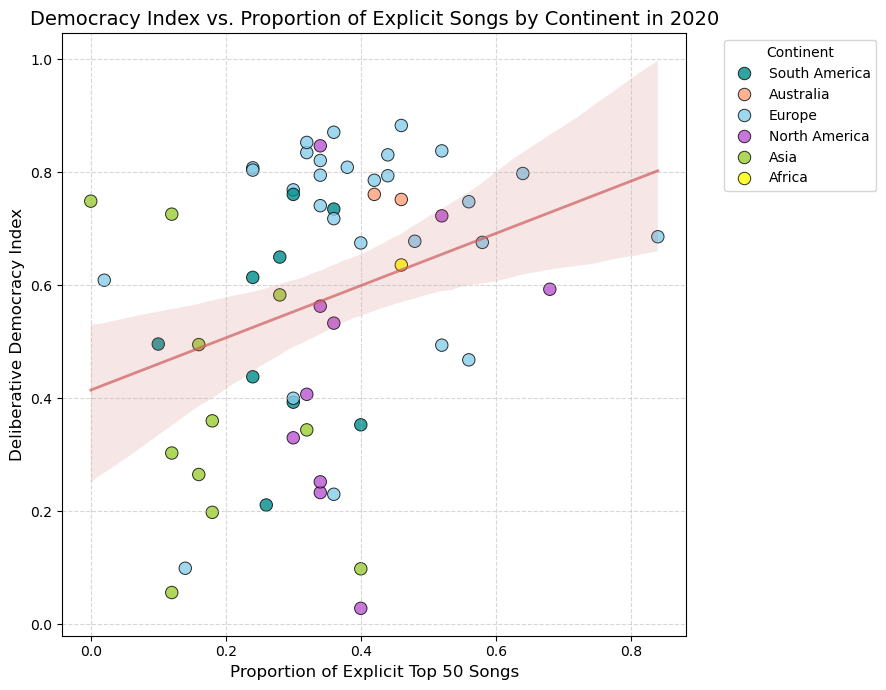

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatterplot colored by continent
plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=merged,
    x="Explicit_Proportion",
    y="Democracy_Index",
    hue="Continent",
    palette= continent_colors,
    s=80,
    alpha=0.8,
    edgecolor="black"
)

# Add regression line (overall trend)
sns.regplot(
    data=merged,
    x="Explicit_Proportion",
    y="Democracy_Index",
    scatter=False,
    color="indianred",
    line_kws={"linewidth": 2, "alpha": 0.7}
)

# Format the plot
plt.title("Democracy Index vs. Proportion of Explicit Songs by Continent in 2020", fontsize=14)
plt.xlabel("Proportion of Explicit Top 50 Songs", fontsize=12)
plt.ylabel("Deliberative Democracy Index", fontsize=12)
plt.legend(title="Continent", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Display
plt.show()

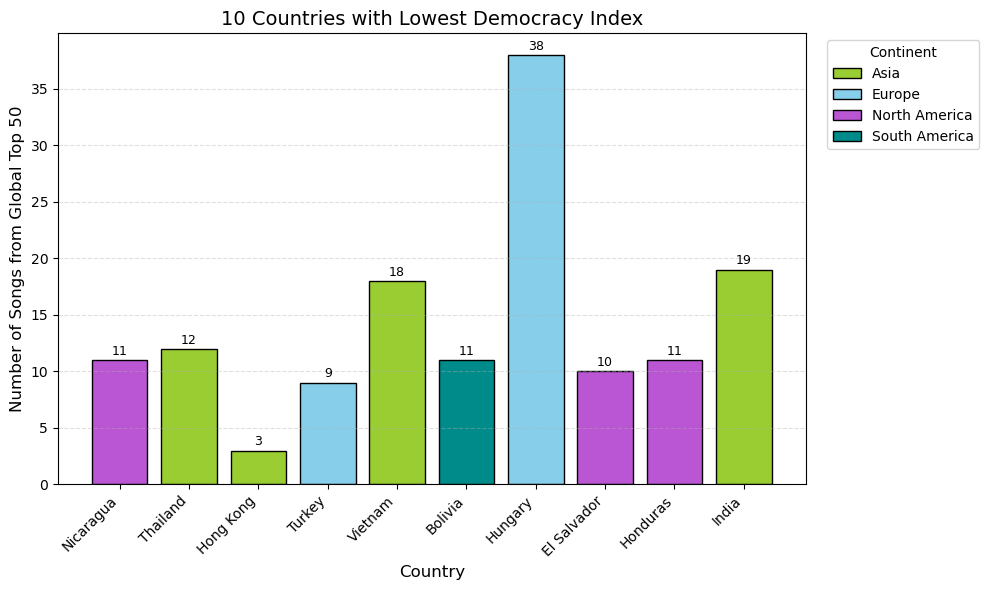

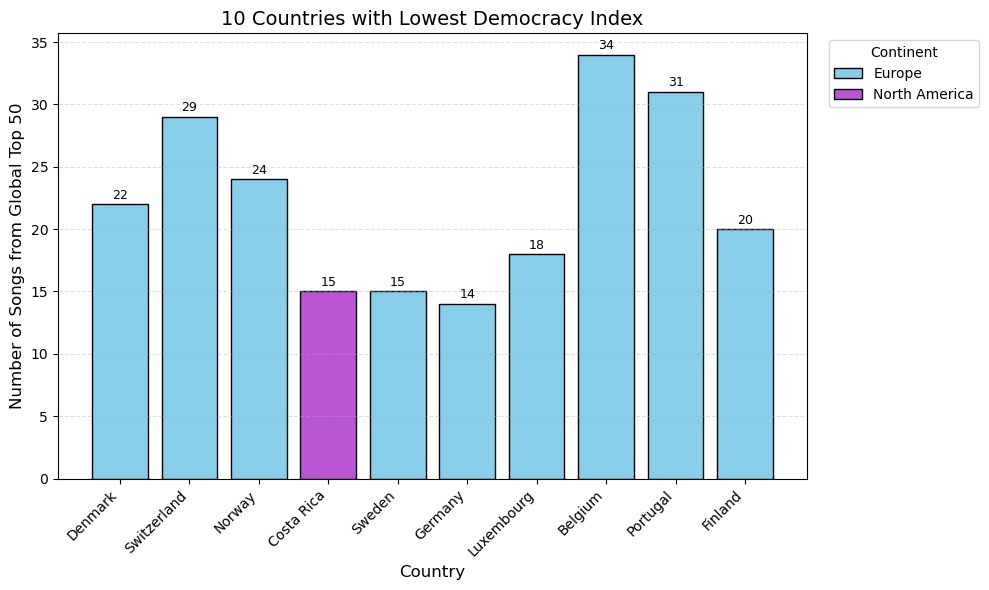

In [133]:
from matplotlib.patches import Patch

# Build Global Top 50 (Title + Artists)
global_top50 = (
    spotify[(spotify["Country"] == "Global") & (spotify["Rank"] <= 50)]
    .assign(song_id=lambda df: df["Title"].str.strip() + " — " + df["Artists"].str.strip())
    ["song_id"]
    .unique()
)
global_top50_set = set(global_top50)

# Build country Top 50 with song IDs
spotify = spotify.assign(song_id=spotify["Title"].str.strip() + " — " + spotify["Artists"].str.strip())
spotify_countries = spotify[(spotify["Country"] != "Global") & (spotify["Rank"] <= 50)].copy()

valid_countries = set(spotify_countries["Country"].unique())
democracy_2020 = democracy_2020[democracy_2020["Country"].isin(valid_countries)].copy()

# Get 10 lowest & 10 highest democracy index countries
lowest10 = democracy_2020.sort_values("Democracy_Index", ascending=True).head(10).copy()
highest10 = democracy_2020.sort_values("Democracy_Index", ascending=False).head(10).copy()

# Count overlap with Global Top 50
def count_overlap(country):
    songs_in_country = set(
        spotify_countries.loc[spotify_countries["Country"] == country, "song_id"].unique()
    )
    return len(songs_in_country & global_top50_set)

lowest10["Overlap"] = lowest10["Country"].apply(count_overlap)
highest10["Overlap"] = highest10["Country"].apply(count_overlap)

# Add Continent info
continent_map = spotify[["Country", "Continent"]].drop_duplicates()
lowest10 = lowest10.merge(continent_map, on="Country", how="left")
highest10 = highest10.merge(continent_map, on="Country", how="left")

# Plot helper function
def plot_bar(df, title):
    plt.figure(figsize=(10, 6))
    
    # Apply color mapping
    colors = df["Continent"].map(lambda c: continent_colors.get(c, "#cccccc"))
    
    # Bar chart
    plt.bar(df["Country"], df["Overlap"], color=colors, edgecolor="black")
    
    # Titles & labels
    plt.title(title, fontsize=14)
    plt.xlabel("Country", fontsize=12)
    plt.ylabel("Number of Songs from Global Top 50", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    
    # Labels above bars
    for x, y in zip(df["Country"], df["Overlap"]):
        plt.text(x, y + 0.2, str(y), ha="center", va="bottom", fontsize=9)
    
    # Legend for continents
    legend_elements = [
        Patch(facecolor=color, edgecolor="black", label=continent)
        for continent, color in continent_colors.items()
        if continent in df["Continent"].unique()
    ]
    plt.legend(handles=legend_elements, title="Continent", bbox_to_anchor=(1.02, 1), loc="upper left")
    
    plt.tight_layout()
    plt.show()

# Plot both charts
plot_bar(lowest10, "10 Countries with Lowest Democracy Index")
plot_bar(highest10, "10 Countries with Lowest Democracy Index")
